In [1]:
import time
import glob as glob
from zipfile import ZipFile
from bs4 import BeautifulSoup
import dateutil.parser as dparser
import datetime
import pandas as pd
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sortedcontainers import SortedSet
import statistics

%matplotlib inline

In [2]:
df = pd.read_csv('/home/shane/Documents/thesis/output/final/failures.csv', parse_dates=['timestamp_dir'])
df['operational_pct'] = df['operational_pct'].astype('float') * 100
df['partial_pct'] = df['partial_pct'].astype('float') * 100
df['major_pct'] = df['major_pct'].astype('float') * 100
df['maint_pct'] = df['maint_pct'].astype('float') * 100
df

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,source,service,timestamp_dir,timestamp_site,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct
0,slack,slack,2020-03-26 12:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
1,slack,slack,2020-03-26 13:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
2,slack,slack,2020-03-26 14:00:02,NaN,10,100.0,0,0.0,0,0.0,0,0.0
3,slack,slack,2020-03-26 15:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
4,slack,slack,2020-03-26 16:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
403998,cloud-google-cloud-platform,google-cloud,2020-06-10 19:00:02,NaN,1,100.0,0,0.0,0,0.0,0,0.0
403999,cloud-google-cloud-platform,google-cloud,2020-06-10 20:00:01,NaN,1,100.0,0,0.0,0,0.0,0,0.0
404000,cloud-google-cloud-platform,google-cloud,2020-06-10 21:00:01,NaN,1,100.0,0,0.0,0,0.0,0,0.0
404001,cloud-google-cloud-platform,google-cloud,2020-06-10 22:00:01,NaN,1,100.0,0,0.0,0,0.0,0,0.0


## Data validation

#### NaN counts

In [3]:
print(df.isna().sum(),'\n')
print(df.isna().sum().sum())

source                      0
service                     0
timestamp_dir               0
timestamp_site          24646
operational_count           0
operational_pct             8
partial_outage_count        0
partial_pct                 8
major_outage_count          0
major_pct                   8
maint_count                 0
maint_pct                   8
dtype: int64 

24678


#### Find rows with NaN (not including timestamp_site)

In [4]:
df_tmp = df.copy()
df_tmp.drop(['timestamp_site'], axis=1, inplace=True)
is_nan = df_tmp.isnull()
row_has_nan = is_nan.any(axis=1)
nan_rows = df[row_has_nan]
nan_rows

,source,service,timestamp_dir,timestamp_site,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct
294985,downdetector-fin-finland,snapchat,2018-09-10 00:00:02,2018-09-10T03:03:04.030439+03:00,0,NaN,0,NaN,0,NaN,0,NaN
317306,downdetector-gbr-great-britain,slack,2018-09-16 02:00:01,2018-09-16T03:01:28.474454+01:00,0,NaN,0,NaN,0,NaN,0,NaN
325877,downrightnow,tumblr,2019-12-01 20:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
328557,downrightnow,netflix,2019-12-08 20:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
328783,downrightnow,gmail,2019-12-09 10:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
335093,downrightnow,linkedin,2019-12-25 20:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
335694,downrightnow,youtube,2019-12-27 10:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
336223,downrightnow,gmail,2019-12-28 19:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN


#### Drop timestamp_site and remaining rows with NaN

In [5]:
df.drop(['timestamp_site'], axis=1, inplace=True)
df.dropna(inplace=True)
df

,source,service,timestamp_dir,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct
0,slack,slack,2020-03-26 12:00:01,10,100.0,0,0.0,0,0.0,0,0.0
1,slack,slack,2020-03-26 13:00:01,10,100.0,0,0.0,0,0.0,0,0.0
2,slack,slack,2020-03-26 14:00:02,10,100.0,0,0.0,0,0.0,0,0.0
3,slack,slack,2020-03-26 15:00:01,10,100.0,0,0.0,0,0.0,0,0.0
4,slack,slack,2020-03-26 16:00:01,10,100.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
403998,cloud-google-cloud-platform,google-cloud,2020-06-10 19:00:02,1,100.0,0,0.0,0,0.0,0,0.0
403999,cloud-google-cloud-platform,google-cloud,2020-06-10 20:00:01,1,100.0,0,0.0,0,0.0,0,0.0
404000,cloud-google-cloud-platform,google-cloud,2020-06-10 21:00:01,1,100.0,0,0.0,0,0.0,0,0.0
404001,cloud-google-cloud-platform,google-cloud,2020-06-10 22:00:01,1,100.0,0,0.0,0,0.0,0,0.0


## General statistics

#### Sum and percentage of status types

In [6]:
operational_sum = df['operational_count'].sum()
partial_outage_sum = df['partial_outage_count'].sum()
major_outage_sum = df['major_outage_count'].sum()
maintenance_sum = df['maint_count'].sum()

total_sum = operational_sum + partial_outage_sum + major_outage_sum + maintenance_sum

print('operatnl sum:', operational_sum, '\tpct:', operational_sum/total_sum*100)
print('p_outage sum:', partial_outage_sum, '\tpct:', partial_outage_sum/total_sum*100)
print('m_outage sum:', major_outage_sum, '\tpct:', major_outage_sum/total_sum*100)
print('maintnce sum:', maintenance_sum, '\tpct:', maintenance_sum/total_sum*100)

operatnl sum: 2632085 	pct: 93.71472904429017
p_outage sum: 172190 	pct: 6.1307819444038945
m_outage sum: 4179 	pct: 0.14879225126699502
maintnce sum: 160 	pct: 0.0056967600389373554


#### Overall averages per source/service grouping

In [7]:
df_mean = df.groupby(['source','service']).agg(mean_op=('operational_pct',np.mean), mean_part=('partial_pct',np.mean), mean_maj=('major_pct',np.mean), mean_maint=('maint_pct',np.mean))
df_mean

mean_op  mean_part  mean_maj  mean_maint
source        service                                                
atlassian     access      100.000000   0.000000  0.000000    0.000000
              bitbucket    99.480476   0.162202  0.081699    0.275623
              confluence   99.456988   0.456774  0.031772    0.054466
              developers   99.877864   0.066020  0.042913    0.013204
              jira-align  100.000000   0.000000  0.000000    0.000000
...                              ...        ...       ...         ...
downrightnow  typepad     100.000000   0.000000  0.000000    0.000000
              yahoomail    99.596774   0.403226  0.000000    0.000000
              youtube     100.000000   0.000000  0.000000    0.000000
github-status github       99.696415   0.271073  0.032511    0.000000
slack         slack        98.016349   1.983651  0.000000    0.000000

[188 rows x 4 columns]

#### Daily averages per source/service grouping

In [8]:
df['days'] = df.timestamp_dir.dt.date
df_grp = df.groupby(['source','service','days']).agg({'operational_pct': 'mean', 'partial_pct': 'mean', 'major_pct': 'mean', 'maint_pct': 'mean'})
df_grp

operational_pct  partial_pct  major_pct  \
source    service days                                                  
atlassian access  2020-03-26       100.000000     0.000000        0.0   
                  2020-03-27       100.000000     0.000000        0.0   
                  2020-03-28       100.000000     0.000000        0.0   
                  2020-03-29       100.000000     0.000000        0.0   
                  2020-03-30       100.000000     0.000000        0.0   
...                                       ...          ...        ...   
slack     slack   2020-06-06        90.000000    10.000000        0.0   
                  2020-06-07        90.000000    10.000000        0.0   
                  2020-06-08        89.166667    10.833333        0.0   
                  2020-06-09        90.000000    10.000000        0.0   
                  2020-06-10        90.000000    10.000000        0.0   

                              maint_pct  
source    service days                   
atlassian access  2020-03-26        0.0  
                  2020-03-27        0.0  
                  2020-03-28        0.0  
                  2020-03-29        0.0  
                  2020-03-30        0.0  
...                                 ...  
slack     slack   2020-06-06        0.0  
                  2020-06-07        0.0  
                  2020-06-08        0.0  
                  2020-06-09        0.0  
                  2020-06-10        0.0  

[17180 rows x 4 columns]

## Figures and plots

In [9]:
sns.set(rc={'figure.figsize':(8,8)})
sns.set(style='white')

#### Boxplot

[Text(0, 0, 'Operational'),
 Text(1, 0, 'Partial Outage'),
 Text(2, 0, 'Major Outage'),
 Text(3, 0, 'Maintenance')]

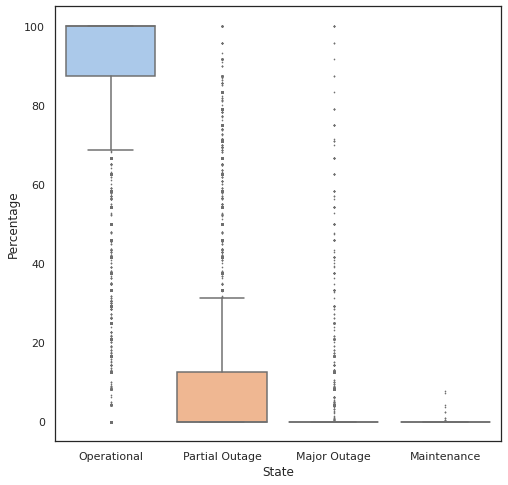

In [10]:
ax = sns.boxplot(x='variable', y='value', palette='pastel', fliersize=0.8, data=pd.melt(df_grp))
ax.set(xlabel='State', ylabel='Percentage')
ax.set_xticklabels(['Operational', 'Partial Outage', 'Major Outage', 'Maintenance'])

#### Letter value plot

[Text(0, 0, 'Operational'),
 Text(1, 0, 'Partial Outage'),
 Text(2, 0, 'Major Outage'),
 Text(3, 0, 'Maintenance')]

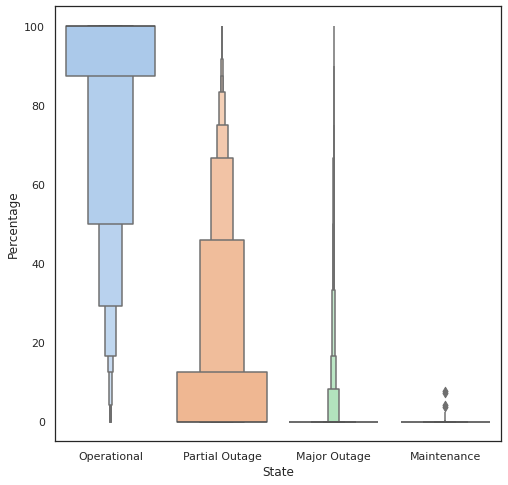

In [11]:
ax2 = sns.boxenplot(x='variable', y='value', palette='pastel', data=pd.melt(df_grp))
ax2.set(xlabel='State', ylabel='Percentage')
ax2.set_xticklabels(['Operational', 'Partial Outage', 'Major Outage', 'Maintenance'])

#### Timeseries

In [12]:
timeseries = df_grp.reset_index().pivot(index='days', columns=['source', 'service'], values='operational_pct')
timeseries

source     atlassian                                                          \
service       access   bitbucket confluence  developers jira-align jira-core   
days                                                                           
2017-10-23       NaN         NaN        NaN         NaN        NaN       NaN   
2017-10-24       NaN         NaN        NaN         NaN        NaN       NaN   
2017-10-25       NaN         NaN        NaN         NaN        NaN       NaN   
2017-10-26       NaN         NaN        NaN         NaN        NaN       NaN   
2017-10-27       NaN         NaN        NaN         NaN        NaN       NaN   
...              ...         ...        ...         ...        ...       ...   
2020-06-06     100.0  100.000000      100.0  100.000000      100.0     100.0   
2020-06-07     100.0  100.000000      100.0  100.000000      100.0     100.0   
2020-06-08     100.0  100.000000      100.0   97.222222      100.0     100.0   
2020-06-09     100.0   99.702381      100.0   98.737374      100.0     100.0   
2020-06-10     100.0   98.511905      100.0  100.000000      100.0     100.0   

source                                                        ...  \
service    jira-service-desk jira-software opsgenie partners  ...   
days                                                          ...   
2017-10-23               NaN           NaN      NaN      NaN  ...   
2017-10-24               NaN           NaN      NaN      NaN  ...   
2017-10-25               NaN           NaN      NaN      NaN  ...   
2017-10-26               NaN           NaN      NaN      NaN  ...   
2017-10-27               NaN           NaN      NaN      NaN  ...   
...                      ...           ...      ...      ...  ...   
2020-06-06             100.0         100.0    100.0    100.0  ...   
2020-06-07             100.0         100.0    100.0    100.0  ...   
2020-06-08             100.0         100.0    100.0    100.0  ...   
2020-06-09             100.0         100.0    100.0    100.0  ...   
2020-06-10             100.0         100.0    100.0    100.0  ...   

source     downrightnow                                                        \
service            ning paypal skype tumblr twitter typepad yahoomail youtube   
days                                                                            
2017-10-23          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   
2017-10-24          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   
2017-10-25          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   
2017-10-26          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   
2017-10-27          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   
...                 ...    ...   ...    ...     ...     ...       ...     ...   
2020-06-06          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   
2020-06-07          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   
2020-06-08          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   
2020-06-09          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   
2020-06-10          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   

source     github-status      slack  
service           github      slack  
days                                 
2017-10-23           NaN        NaN  
2017-10-24           NaN        NaN  
2017-10-25           NaN        NaN  
2017-10-26           NaN        NaN  
2017-10-27           NaN        NaN  
...                  ...        ...  
2020-06-06    100.000000  90.000000  
2020-06-07    100.000000  90.000000  
2020-06-08    100.000000  89.166667  
2020-06-09    100.000000  90.000000  
2020-06-10     98.958333  90.000000  

[960 rows x 188 columns]

In [13]:
# fig = timeseries.reset_index()
# fig.plot(x = 'days', sharex=True, sharey=True, marker=".", linestyle="", markersize=5, layout = (32,6), figsize = (48, 240), subplots=True, legend=True)
# plt.xlabel('Date')
# plt.ylabel('% (sub-)services operational')
# plt.savefig('/home/shane/Documents/test/plots.pdf')

## Detailed statistics

#### Frequency of status state changes per source/service

In [14]:
df_grouped = df.groupby(['source','service'])
df_grouped.head()

,source,service,timestamp_dir,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct,days
0,slack,slack,2020-03-26 12:00:01,10,100.0,0,0.0,0,0.0,0,0.0,2020-03-26
1,slack,slack,2020-03-26 13:00:01,10,100.0,0,0.0,0,0.0,0,0.0,2020-03-26
2,slack,slack,2020-03-26 14:00:02,10,100.0,0,0.0,0,0.0,0,0.0,2020-03-26
3,slack,slack,2020-03-26 15:00:01,10,100.0,0,0.0,0,0.0,0,0.0,2020-03-26
4,slack,slack,2020-03-26 16:00:01,10,100.0,0,0.0,0,0.0,0,0.0,2020-03-26
...,...,...,...,...,...,...,...,...,...,...,...,...
381192,cloud-google-cloud-platform,google-cloud,2017-11-01 04:00:01,1,100.0,0,0.0,0,0.0,0,0.0,2017-11-01
381193,cloud-google-cloud-platform,google-cloud,2017-11-01 05:00:01,1,100.0,0,0.0,0,0.0,0,0.0,2017-11-01
381194,cloud-google-cloud-platform,google-cloud,2017-11-01 06:00:01,1,100.0,0,0.0,0,0.0,0,0.0,2017-11-01
381195,cloud-google-cloud-platform,google-cloud,2017-11-01 07:00:01,1,100.0,0,0.0,0,0.0,0,0.0,2017-11-01


In [15]:
def get_state_changes():
    state_changes = []
    for name, group in df_grouped:
        sc_op = group[group['operational_pct'].diff() != 0].timestamp_dir.tolist()
        sc_po = group[group['partial_pct'].diff() != 0].timestamp_dir.tolist()
        sc_mo = group[group['major_pct'].diff() != 0].timestamp_dir.tolist()
        sc_ma = group[group['maint_pct'].diff() != 0].timestamp_dir.tolist()
        sc_set = SortedSet(sc_op + sc_po + sc_mo + sc_ma)
        sc_ts = group[group['timestamp_dir'].diff() > datetime.timedelta(days=1)].timestamp_dir.tolist()
        state_changes.append([name, len(group), sc_set, sc_ts])
    return state_changes

#### MTBSC per source/service grouping

In [24]:
state_changes = get_state_changes()
mtbsc_stats = []
for group in state_changes:
    grouping = group[0]
    num_records = group[1]
    changes = group[2]
    time_gaps = group[3]
    num_changes = len(changes)-1

    mtbsc = []
    previous = changes.pop(0)
    
    for x in range(0, len(changes)):
        current = changes.pop(0)
        if current in time_gaps:
            previous = current
            continue
        mtbsc.append(current - previous)
        previous = current
    mtbsc_mean = pd.to_timedelta(mtbsc).mean()
    mtbsc_stats.append([grouping, num_records, num_changes, round(num_changes/num_records*100,2), mtbsc_mean])

In [25]:
df_mtbsc_stats = pd.DataFrame(mtbsc_stats, columns=['grouping','records','state_changes','pct_state_changes','mean'])
df_mtbsc_stats

,grouping,records,state_changes,state_changes_pct,mean
0,"(atlassian, access)",1835,0,0.00,NaT
1,"(atlassian, bitbucket)",1836,41,2.23,1 days 20:19:01.463414634
2,"(atlassian, confluence)",1836,14,0.76,4 days 23:25:42.857142857
3,"(atlassian, developers)",1836,12,0.65,6 days 05:25:00
4,"(atlassian, jira-align)",1835,0,0.00,NaT
...,...,...,...,...,...
183,"(downrightnow, typepad)",744,0,0.00,NaT
184,"(downrightnow, yahoomail)",744,6,0.81,0 days 14:20:00
185,"(downrightnow, youtube)",743,0,0.00,NaT
186,"(github-status, github)",9612,113,1.18,3 days 13:01:35.575221238


In [33]:
# df_mtbsc_stats.dropna(inplace=True)
# ax3 = sns.boxenplot(y='mean', palette='pastel', data=df_mtbsc_stats)
# ax3.set(xlabel='State', ylabel='Percentage')
# ax3.set_xticklabels(['Operational', 'Partial Outage', 'Major Outage', 'Maintenance'])